In [ ]:
import os
os.chdir('/Users/philippratz/Documents/Uni/PhD/UQAM/courses/RL/mcgill_precup/project/')

import numpy as np
import pandas as pd
import random
from collections import namedtuple, deque
from copy import deepcopy


# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
%load_ext pycodestyle_magic
%load_ext autoreload

In [3]:
%autoreload 2
from main.environment.simple_environment import SimpleEconEnvironment

In [225]:
class BaseMLP(nn.Module):
    def __init__(self, arch,
                 input_size=2,
                 output_size = 1,
                 dropout=0.1):
        super().__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        self._set_arch(arch, input_size)
        
    def _set_arch(self, arch, input_size):
        current_size = input_size
        for lay_size in arch:
            self.layers.append(nn.Linear(current_size, lay_size))
            current_size = lay_size
            
        self.final_layer = nn.Linear(current_size, self.output_size)

    def forward(self, x):
        for lay_ in self.layers:
            x = F.relu(lay_(x))
            x = self.dropout(x)
            
        x = self.final_layer(x)
        
        return x
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
def init_weights(lay):
    if isinstance(lay, nn.Linear):
        torch.nn.init.xavier_normal_(lay.weight)
        lay.bias.data.fill_(1.0)
    

def initalize_replay_buffer(enviornment_, state_memory_length=1, players=2):
    replay_buffer = ReplayMemory(1000)
    
    state_vec = np.random.uniform(low=1, high=2.5, size=(state_memory_length*players, ))

    for simple_mem in range(128):
        # will left append new states so need the last two prices
        all_demands = enviornment_(state_vec[-1], state_vec[-2])

        demand_1 = all_demands[0]

        state = torch.from_numpy(np.float32(state_vec)).reshape(1,-1)
        action = torch.tensor([random.choices(range(15), k=1)]).reshape(1,-1)
        # get last price (aka players price from state)
        reward = torch.tensor((state_vec[-1] - 1)*demand_1).reshape(1,-1)

        # sample new prices
        new_prices = np.random.uniform(low=1, high=2.5, size=(players,))

        # set up next state
        next_state_vec = np.concatenate([state_vec[players:], new_prices])
        next_state = torch.from_numpy(np.float32(next_state_vec)).reshape(1,-1)

        replay_buffer.push(state, action, next_state, reward)

        state_vec = next_state_vec

    return replay_buffer

def train_model(replay_buffer,
                model,
                target_model,
                optimizer,
                batch_size=128, 
                gamma=0.99):

    trans_sample = replay_buffer.sample(batch_size)
    batch = Transition(*zip(*trans_sample))

    sample_state = torch.cat(batch.state)
    sample_reward = torch.cat(batch.reward)
    sample_action = torch.cat(batch.action)
    sample_next_state = torch.cat(batch.next_state)

    # cast to avoid issues with torch
    sample_state = sample_state.type(torch.FloatTensor)
    sample_next_state = sample_next_state.type(torch.FloatTensor)

    q_values_hat = model(sample_state).gather(1,sample_action)

    # No grad here as we do not optimize target net
    target_model.eval()
    with torch.no_grad():
        next_q_val, _ = target_model(sample_next_state).max(1)
    target_model.train()
    
    target_value = sample_reward.squeeze() + gamma* next_q_val
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(q_values_hat.squeeze(), target_value)

    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 100)
    optimizer.step()


def soft_update_nets(model, target_model, tau):
    target_states = target_model.state_dict()
    model_states = model.state_dict()

    for key in model_states:
        target_states[key] = tau*model_states[key] + (1-tau)*target_states[key]
    target_model.load_state_dict(target_states)


def select_action_training(model, state, epsilon, n_actions=15):
     if np.random.uniform() > epsilon:
        model.eval()
        with torch.no_grad():
            _, action_idx = model(state).reshape(1,-1).max(1)

        model.train()
        return action_idx
     else:
        return torch.tensor([random.choices(range(n_actions), k=1)])
    

In [202]:
list(action_dict.values())[-8:]

[1.5964649999999998,
 1.6519281428571428,
 1.7073912857142857,
 1.7628544285714285,
 1.8183175714285715,
 1.8737807142857141,
 1.9292438571428572,
 1.984707]

In [205]:
envir_two_agents = SimpleEconEnvironment()

In [214]:
state

tensor([[1.7074, 1.6519]])

In [215]:
buf_1 = ReplayMemory(10000)
buf_2 = ReplayMemory(10000)

for k in range(10000):
    price_a1 = np.random.choice(list(action_dict.values())[-8:])
    price_a2 = np.random.choice(list(action_dict.values())[-8:])

    action_a1 = torch.tensor(price_a1, dtype=torch.float32)
    action_a2 = torch.tensor(price_a1, dtype=torch.float32)

    price_tensor = torch.tensor([price_a1, price_a2], 
                                                dtype=torch.float32).reshape(1,-1)
                    
    demand_1, demand_2 = envir_two_agents(price_a1, price_a2)

    reward_a1 = torch.tensor((price_a1 - 1)*demand_1, dtype=torch.float32).reshape(1,-1)
    reward_a2 = torch.tensor((price_a2 - 1)*demand_2, dtype=torch.float32).reshape(1,-1)

    next_state = torch.cat([state[:,players:], price_tensor], 1)

    buf_1.push(state, action_a1.reshape(1,1), next_state, reward_a1)
    buf_2.push(state, action_a2.reshape(1,1), next_state, reward_a2)

    state = next_state


In [216]:
with open('data/buffers/buf_1.pkl', 'wb') as con_:
    pickle.dump(buf_1, con_)

with open('data/buffers/buf_2.pkl', 'wb') as con_:
    pickle.dump(buf_2, con_)

In [ ]:
class DQNAgent:
    def __init__(self, 
                 base_model: nn.Module, 
                 replay_buffer: ReplayMemory, 
                 gamma: float, 
                 lr: float,
                 weight_decay: float, 
                 tau: float, 
                 batch_size: int,
                 n_actions=15, 
                 loss_fct = nn.SmoothL1Loss()) -> None:
        self.policy_net = base_model
        self.target_net = deepcopy(base_model)
        self.buffer = replay_buffer
        self.optimizer = optim.AdamW(self.policy_net.parameters(),
                                     lr=lr,
                                     amsgrad=True,
                                     weight_decay=weight_decay)
        self.tau =tau
        self.gamma = gamma
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.criterion = loss_fct
        
        # Initialize nets
        self.policy_net.apply(self._init_weights)
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def _init_weights(self, lay):
        if isinstance(lay, nn.Linear):
            torch.nn.init.xavier_normal_(lay.weight)
            lay.bias.data.fill_(1.0)

    def sample_action(self, state, epsilon):
        if np.random.uniform() > epsilon:
            self.policy_net.eval()
            with torch.no_grad():
                action_idx = self.policy_net(state).argmax()
            self.policy_net.train()
            return action_idx
        else:
            return torch.tensor(random.choices(range(self.n_actions), k=1)[0])

    def update_target(self):
        model_states = self.policy_net.state_dict()
        target_states = self.target_net.state_dict()

        for key in model_states:
            target_states[key] = self.tau*model_states[key] + (1-self.tau)*target_states[key]
        self.target_net.load_state_dict(target_states)

    def update_policy(self):
        if len(self.buffer) < self.batch_size:
            return
        sample = self.buffer.sample(self.batch_size)
        batch = Transition(*zip(*sample))

        state_s = torch.cat(batch.state)
        reward_s = torch.cat(batch.reward)
        action_s = torch.cat(batch.action)
        next_state_s = torch.cat(batch.next_state)

        # Get updates
        q_values_hat = self.policy_net(state_s).gather(1, action_s).squeeze()
        
        with torch.no_grad():
            self.target_net.eval()
            next_q_values, _ = self.target_net(next_state_s).max(1)
            self.target_net.train()

        target_value = self.gamma * next_q_values.squeeze() + reward_s.squeeze()

        policy_loss = self.criterion(q_values_hat, target_value)
        self.optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(),
                                        100)
        self.optimizer.step()




In [ ]:
tau = 0.025
tau_decay=0
learning_rate=0.025

In [385]:
for lr in [0.025,0.05,0.1]:

    gamma=0.99
   # lr=0.05
    weight_decay=1e-6
    beta = 2e-5
    tau=0.025
    tau_decay = 1e-7
    players=2
    state_memory=1

    batch_size=64
    arch_ = [7,7,7]
    dropout=0

    eps=0.95

    num_experiments = 1
    num_steps = 450000
    shift_delay = 1

    all_rewards_1 = []
    all_rewards_2 = []

    for exper_ in range(num_experiments):

        environment_two_actors = SimpleEconEnvironment()

        base_net_1 = BaseMLP(arch_,
                            input_size=players*state_memory,
                            output_size=15,
                            dropout=dropout)
        buffer_1 = ReplayMemory(1000)
        agent_1 = DQNAgent(base_net_1,
                        buffer_1,
                        gamma=gamma,
                        lr=lr, 
                        weight_decay=weight_decay, 
                        tau=tau, 
                        batch_size=batch_size)

        base_net_2 = BaseMLP(arch_,
                            input_size=players*state_memory,
                            output_size=15,
                            dropout=dropout)
        buffer_2 = ReplayMemory(1000)
        agent_2 = DQNAgent(base_net_2,
                        buffer_2,
                        gamma=gamma,
                        lr=lr, 
                        weight_decay=weight_decay, 
                        tau=tau, 
                        batch_size=batch_size)
        
        # Initialize state
        np.random.seed(exper_)
        state = torch.tensor(np.random.uniform(low=1.47,
                                                high=2,
                                                size=(players*state_memory,)),
                            dtype=torch.float32).reshape(1,players*state_memory)
        
        # create action to value dict
        linspace_ = np.linspace(1.47293 - 0.1*(1.92-1.47293),
                                1.92  + 0.1*(1.92-1.47293), 
                                15)
        action_dict = dict(zip(range(15), linspace_))

        rewards_1 = []
        rewards_2 = []

        for step in range(num_steps):
            action_1 = agent_1.sample_action(state, epsilon=eps)
            action_val_1 = action_dict[int(action_1)]

            action_2 = agent_2.sample_action(state, epsilon=eps)
            action_val_2 = action_dict[int(action_2)]
                    
            demand_1, demand_2 = environment_two_actors(action_val_1, action_val_2)

            reward_a1 = torch.tensor((action_val_1 - 1)*demand_1, dtype=torch.float32).reshape(1,-1)
            reward_a2 = torch.tensor((action_val_2 - 1)*demand_2, dtype=torch.float32).reshape(1,-1)

            rewards_1.append((action_val_1 - 1)*demand_1)
            rewards_2.append((action_val_2 - 1)*demand_2)

            price_tensor = torch.tensor([action_val_1, action_val_2],
                                        dtype=torch.float32).reshape(1,-1)
            next_state = torch.cat([state[:,players:], price_tensor], 1)

            agent_1.buffer.push(state, action_1.reshape(1,1), next_state, reward_a1)
            agent_2.buffer.push(state, action_2.reshape(1,1), next_state, reward_a2)

            agent_1.update_policy()
            agent_2.update_policy()

            state = next_state

            eps = np.exp(-step*beta)

            if step % shift_delay == 0:
                agent_1.update_target()
                agent_2.update_target()

                agent_1.tau = tau*(1-tau_decay)
                agent_2.tau = tau*(1-tau_decay)

        print(np.mean(rewards_1[-1000:]))
        print(np.mean(rewards_2[-1000:]))
        all_rewards_1.append(rewards_1)
        all_rewards_2.append(rewards_2)


0.24004402204846026
0.241292763053102
0.22796586286014844
0.22832776285067535
0.22486154052998814
0.22668472812871998


In [386]:
for weight_decay in [1e-6,5e-6,1e-5]:

    gamma=0.99
    lr=0.05
    #weight_decay=1e-6
    beta = 2e-5
    tau=0.025
    tau_decay = 1e-7
    players=2
    state_memory=1

    batch_size=64
    arch_ = [7,7,7]
    dropout=0

    eps=0.95

    num_experiments = 1
    num_steps = 450000
    shift_delay = 1

    all_rewards_1 = []
    all_rewards_2 = []

    for exper_ in range(num_experiments):

        environment_two_actors = SimpleEconEnvironment()

        base_net_1 = BaseMLP(arch_,
                            input_size=players*state_memory,
                            output_size=15,
                            dropout=dropout)
        buffer_1 = ReplayMemory(1000)
        agent_1 = DQNAgent(base_net_1,
                        buffer_1,
                        gamma=gamma,
                        lr=lr, 
                        weight_decay=weight_decay, 
                        tau=tau, 
                        batch_size=batch_size)

        base_net_2 = BaseMLP(arch_,
                            input_size=players*state_memory,
                            output_size=15,
                            dropout=dropout)
        buffer_2 = ReplayMemory(1000)
        agent_2 = DQNAgent(base_net_2,
                        buffer_2,
                        gamma=gamma,
                        lr=lr, 
                        weight_decay=weight_decay, 
                        tau=tau, 
                        batch_size=batch_size)
        
        # Initialize state
        np.random.seed(exper_)
        state = torch.tensor(np.random.uniform(low=1.47,
                                                high=2,
                                                size=(players*state_memory,)),
                            dtype=torch.float32).reshape(1,players*state_memory)
        
        # create action to value dict
        linspace_ = np.linspace(1.47293 - 0.1*(1.92-1.47293),
                                1.92  + 0.1*(1.92-1.47293), 
                                15)
        action_dict = dict(zip(range(15), linspace_))

        rewards_1 = []
        rewards_2 = []

        for step in range(num_steps):
            action_1 = agent_1.sample_action(state, epsilon=eps)
            action_val_1 = action_dict[int(action_1)]

            action_2 = agent_2.sample_action(state, epsilon=eps)
            action_val_2 = action_dict[int(action_2)]
                    
            demand_1, demand_2 = environment_two_actors(action_val_1, action_val_2)

            reward_a1 = torch.tensor((action_val_1 - 1)*demand_1, dtype=torch.float32).reshape(1,-1)
            reward_a2 = torch.tensor((action_val_2 - 1)*demand_2, dtype=torch.float32).reshape(1,-1)

            rewards_1.append((action_val_1 - 1)*demand_1)
            rewards_2.append((action_val_2 - 1)*demand_2)

            price_tensor = torch.tensor([action_val_1, action_val_2],
                                        dtype=torch.float32).reshape(1,-1)
            next_state = torch.cat([state[:,players:], price_tensor], 1)

            agent_1.buffer.push(state, action_1.reshape(1,1), next_state, reward_a1)
            agent_2.buffer.push(state, action_2.reshape(1,1), next_state, reward_a2)

            agent_1.update_policy()
            agent_2.update_policy()

            state = next_state

            eps = np.exp(-step*beta)

            if step % shift_delay == 0:
                agent_1.update_target()
                agent_2.update_target()

                agent_1.tau = tau*(1-tau_decay)
                agent_2.tau = tau*(1-tau_decay)

        print(np.mean(rewards_1[-1000:]))
        print(np.mean(rewards_2[-1000:]))
        all_rewards_1.append(rewards_1)
        all_rewards_2.append(rewards_2)


0.22712185313899638
0.22629991149930395
0.22888400004439208
0.23146147050600574
0.22649022832103408
0.22633739465984404


In [387]:
for beta in [2e-5, 5e-5, 9e-5]:

    gamma=0.99
    lr=0.05
    weight_decay=1e-6
   # beta = 2e-5
    tau=0.025
    tau_decay = 1e-7
    players=2
    state_memory=1

    batch_size=64
    arch_ = [7,7,7]
    dropout=0

    eps=0.95

    num_experiments = 1
    num_steps = 450000
    shift_delay = 1

    all_rewards_1 = []
    all_rewards_2 = []

    for exper_ in range(num_experiments):

        environment_two_actors = SimpleEconEnvironment()

        base_net_1 = BaseMLP(arch_,
                            input_size=players*state_memory,
                            output_size=15,
                            dropout=dropout)
        buffer_1 = ReplayMemory(1000)
        agent_1 = DQNAgent(base_net_1,
                        buffer_1,
                        gamma=gamma,
                        lr=lr, 
                        weight_decay=weight_decay, 
                        tau=tau, 
                        batch_size=batch_size)

        base_net_2 = BaseMLP(arch_,
                            input_size=players*state_memory,
                            output_size=15,
                            dropout=dropout)
        buffer_2 = ReplayMemory(1000)
        agent_2 = DQNAgent(base_net_2,
                        buffer_2,
                        gamma=gamma,
                        lr=lr, 
                        weight_decay=weight_decay, 
                        tau=tau, 
                        batch_size=batch_size)
        
        # Initialize state
        np.random.seed(exper_)
        state = torch.tensor(np.random.uniform(low=1.47,
                                                high=2,
                                                size=(players*state_memory,)),
                            dtype=torch.float32).reshape(1,players*state_memory)
        
        # create action to value dict
        linspace_ = np.linspace(1.47293 - 0.1*(1.92-1.47293),
                                1.92  + 0.1*(1.92-1.47293), 
                                15)
        action_dict = dict(zip(range(15), linspace_))

        rewards_1 = []
        rewards_2 = []

        for step in range(num_steps):
            action_1 = agent_1.sample_action(state, epsilon=eps)
            action_val_1 = action_dict[int(action_1)]

            action_2 = agent_2.sample_action(state, epsilon=eps)
            action_val_2 = action_dict[int(action_2)]
                    
            demand_1, demand_2 = environment_two_actors(action_val_1, action_val_2)

            reward_a1 = torch.tensor((action_val_1 - 1)*demand_1, dtype=torch.float32).reshape(1,-1)
            reward_a2 = torch.tensor((action_val_2 - 1)*demand_2, dtype=torch.float32).reshape(1,-1)

            rewards_1.append((action_val_1 - 1)*demand_1)
            rewards_2.append((action_val_2 - 1)*demand_2)

            price_tensor = torch.tensor([action_val_1, action_val_2],
                                        dtype=torch.float32).reshape(1,-1)
            next_state = torch.cat([state[:,players:], price_tensor], 1)

            agent_1.buffer.push(state, action_1.reshape(1,1), next_state, reward_a1)
            agent_2.buffer.push(state, action_2.reshape(1,1), next_state, reward_a2)

            agent_1.update_policy()
            agent_2.update_policy()

            state = next_state

            eps = np.exp(-step*beta)

            if step % shift_delay == 0:
                agent_1.update_target()
                agent_2.update_target()

                agent_1.tau = tau*(1-tau_decay)
                agent_2.tau = tau*(1-tau_decay)

        print(np.mean(rewards_1[-1000:]))
        print(np.mean(rewards_2[-1000:]))
        all_rewards_1.append(rewards_1)
        all_rewards_2.append(rewards_2)


0.22427730601608065
0.22435579612703935
0.2180203634877009
0.2207161299204078
0.22511726863533107
0.2239138211210367


In [388]:
for state_memory in [1,5,10]:

    gamma=0.99
    lr=0.05
    weight_decay=1e-6
    beta = 2e-5
    tau=0.025
    tau_decay = 1e-7
    players=2
    #state_memory=1

    batch_size=64
    arch_ = [7,7,7]
    dropout=0

    eps=0.95

    num_experiments = 1
    num_steps = 450000
    shift_delay = 1

    all_rewards_1 = []
    all_rewards_2 = []

    for exper_ in range(num_experiments):

        environment_two_actors = SimpleEconEnvironment()

        base_net_1 = BaseMLP(arch_,
                            input_size=players*state_memory,
                            output_size=15,
                            dropout=dropout)
        buffer_1 = ReplayMemory(1000)
        agent_1 = DQNAgent(base_net_1,
                        buffer_1,
                        gamma=gamma,
                        lr=lr, 
                        weight_decay=weight_decay, 
                        tau=tau, 
                        batch_size=batch_size)

        base_net_2 = BaseMLP(arch_,
                            input_size=players*state_memory,
                            output_size=15,
                            dropout=dropout)
        buffer_2 = ReplayMemory(1000)
        agent_2 = DQNAgent(base_net_2,
                        buffer_2,
                        gamma=gamma,
                        lr=lr, 
                        weight_decay=weight_decay, 
                        tau=tau, 
                        batch_size=batch_size)
        
        # Initialize state
        np.random.seed(exper_)
        state = torch.tensor(np.random.uniform(low=1.47,
                                                high=2,
                                                size=(players*state_memory,)),
                            dtype=torch.float32).reshape(1,players*state_memory)
        
        # create action to value dict
        linspace_ = np.linspace(1.47293 - 0.1*(1.92-1.47293),
                                1.92  + 0.1*(1.92-1.47293), 
                                15)
        action_dict = dict(zip(range(15), linspace_))

        rewards_1 = []
        rewards_2 = []

        for step in range(num_steps):
            action_1 = agent_1.sample_action(state, epsilon=eps)
            action_val_1 = action_dict[int(action_1)]

            action_2 = agent_2.sample_action(state, epsilon=eps)
            action_val_2 = action_dict[int(action_2)]
                    
            demand_1, demand_2 = environment_two_actors(action_val_1, action_val_2)

            reward_a1 = torch.tensor((action_val_1 - 1)*demand_1, dtype=torch.float32).reshape(1,-1)
            reward_a2 = torch.tensor((action_val_2 - 1)*demand_2, dtype=torch.float32).reshape(1,-1)

            rewards_1.append((action_val_1 - 1)*demand_1)
            rewards_2.append((action_val_2 - 1)*demand_2)

            price_tensor = torch.tensor([action_val_1, action_val_2],
                                        dtype=torch.float32).reshape(1,-1)
            next_state = torch.cat([state[:,players:], price_tensor], 1)

            agent_1.buffer.push(state, action_1.reshape(1,1), next_state, reward_a1)
            agent_2.buffer.push(state, action_2.reshape(1,1), next_state, reward_a2)

            agent_1.update_policy()
            agent_2.update_policy()

            state = next_state

            eps = np.exp(-step*beta)

            if step % shift_delay == 0:
                agent_1.update_target()
                agent_2.update_target()

                agent_1.tau = tau*(1-tau_decay)
                agent_2.tau = tau*(1-tau_decay)

        print(np.mean(rewards_1[-1000:]))
        print(np.mean(rewards_2[-1000:]))
        all_rewards_1.append(rewards_1)
        all_rewards_2.append(rewards_2)


0.22435373347128126
0.22536834781513934
0.22661782363789928
0.2277638721854143
0.2273520386907497
0.22893526606751385


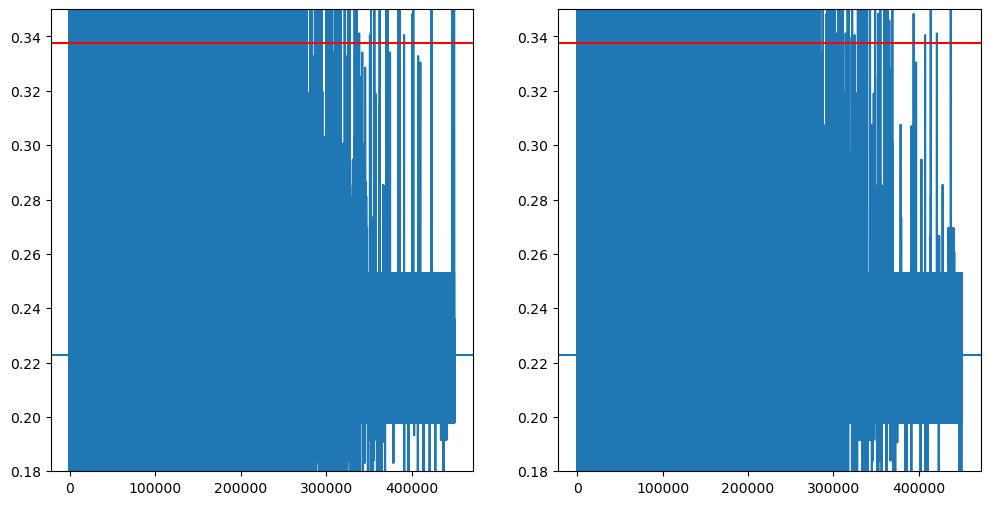

In [389]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

# ax1.plot(pd.DataFrame(all_rewards_1).mean(axis=0))
# ax2.plot(pd.DataFrame(all_rewards_2).mean(axis=0))

ax1.plot(pd.DataFrame(all_rewards_1[0]))
ax2.plot(pd.DataFrame(all_rewards_2[0]))

ax1.set_ylim(0.18, .35)
ax2.set_ylim(0.18, .35)

ax1.axhline(0.47137645*.47293, 0, num_steps)
ax2.axhline(0.47137645*.47293, 0, num_steps)

ax1.axhline(0.36486244*.92498, 0, num_steps, c='red')
ax2.axhline(0.36486244*.92498, 0, num_steps, c='red')

In [384]:
np.mean(rewards_1[-1000:])

0.23537327527781662

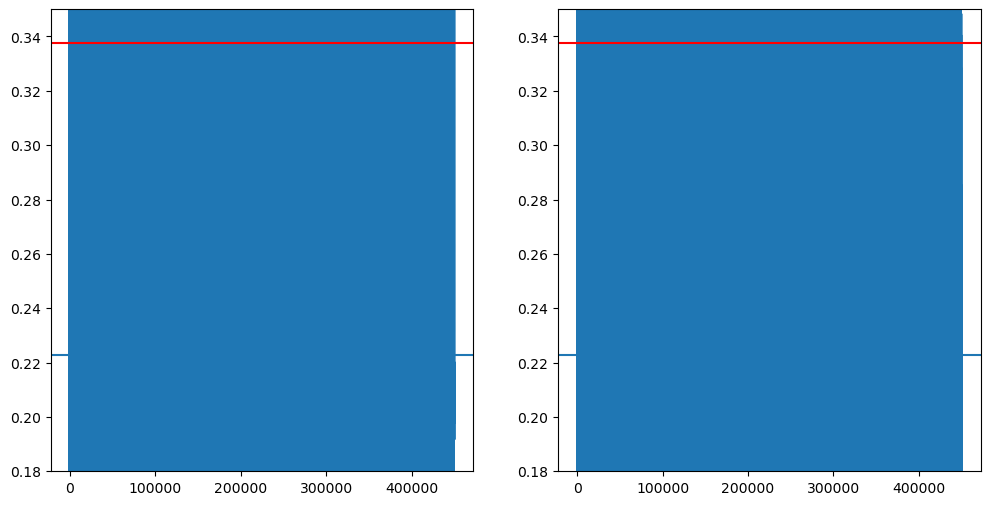

In [382]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

# ax1.plot(pd.DataFrame(all_rewards_1).mean(axis=0))
# ax2.plot(pd.DataFrame(all_rewards_2).mean(axis=0))

ax1.plot(pd.DataFrame(all_rewards_1[0]))
ax2.plot(pd.DataFrame(all_rewards_2[0]))

ax1.set_ylim(0.18, .35)
ax2.set_ylim(0.18, .35)

ax1.axhline(0.47137645*.47293, 0, num_steps)
ax2.axhline(0.47137645*.47293, 0, num_steps)

ax1.axhline(0.36486244*.92498, 0, num_steps, c='red')
ax2.axhline(0.36486244*.92498, 0, num_steps, c='red')

KeyboardInterrupt: 

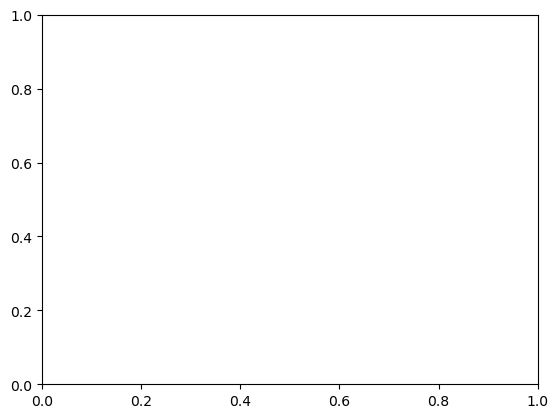

In [376]:
plt.plot(pd.DataFrame(all_rewards_1))

In [359]:
sample = agent_1.buffer.sample(64)
batch = Transition(*zip(*sample))

state_s = torch.cat(batch.state)
reward_s = torch.cat(batch.reward)
action_s = torch.cat(batch.action)
next_state_s = torch.cat(batch.next_state)

In [ ]:
q_values_hat = self.policy_net(state_s).gather(1, action_s)
        
        with torch.no_grad():
            self.target_net.eval()
            next_q_values, _ = self.target_net(next_state_s).max(1)
            self.target_net.train()

        target_value = self.gamma * next_q_values.squeeze() + reward_s.squeeze()

In [361]:
qhat = agent_1.policy_net(state_s).gather(1, action_s)
with torch.no_grad():
    agent_1.target_net.eval()
    next_q_values, _ = agent_1.target_net(next_state_s).max(1)
    agent_1.target_net.train()

In [366]:
qhat.squeeze()

tensor([3.6469, 3.6369, 3.5992, 3.6818, 3.6447, 3.6549, 3.6028, 3.6412, 3.6468,
        3.6558, 3.6638, 3.6039, 3.6468, 3.6568, 3.6033, 3.6126, 3.6184, 3.6468,
        3.6414, 3.6217, 3.6044, 3.6468, 3.6568, 3.6564, 3.6626, 3.6478, 3.6372,
        3.6171, 3.5895, 3.6472, 3.6117, 3.6389, 3.6468, 3.6240, 3.6163, 3.6861,
        3.6468, 3.6447, 3.6197, 3.6474, 3.6033, 3.6145, 3.6354, 3.6468, 3.6359,
        3.5891, 3.6328, 3.6885, 3.6341, 3.6469, 3.6502, 3.6416, 3.6634, 3.6237,
        3.6752, 3.6460, 3.6495, 3.6373, 3.6128, 3.6486, 3.6642, 3.6130, 3.6465,
        3.6638], grad_fn=<SqueezeBackward0>)

In [362]:
target_value = 0.95 * next_q_values.squeeze() + reward_s.squeeze()

In [364]:
target_value.shape

torch.Size([64])

In [353]:
agent_1.policy_net(test_tensor).gather()

tensor([[ 1.1024,  0.5910,  1.5797, -0.1327,  2.5480,  3.4476,  1.0845, -0.2983,
         -2.0124, -0.1398,  2.6249,  1.3908, -0.5172,  1.2136,  1.7763],
        [ 0.9654,  0.4125,  1.5071, -0.1133,  2.8315,  3.6536,  0.8718, -0.2332,
         -2.1611, -0.4334,  2.6949,  1.4415, -0.6733,  1.0546,  1.9853],
        [ 1.0461,  0.5776,  1.5871, -0.0735,  2.6515,  3.5170,  1.0234, -0.2181,
         -1.9753, -0.2837,  2.6417,  1.4227, -0.5745,  1.1595,  1.8194],
        [ 0.9571,  0.3916,  1.4880, -0.0962,  2.8291,  3.6332,  0.8428, -0.2164,
         -2.1325, -0.4308,  2.6806,  1.4376, -0.6628,  1.0321,  1.9980],
        [ 0.9886,  0.5171,  1.5300, -0.0971,  2.7215,  3.5419,  0.9732, -0.2029,
         -2.0480, -0.3512,  2.6240,  1.4244, -0.5956,  1.1227,  1.8809],
        [ 1.0153,  0.6321,  1.5992, -0.1341,  2.6765,  3.5350,  1.1035, -0.2276,
         -2.0606, -0.3231,  2.6261,  1.4306, -0.5789,  1.2227,  1.7816],
        [ 0.9981,  0.5297,  1.5407, -0.0946,  2.7095,  3.5379,  0.9846, -0.2

In [329]:
gamma=0.95
lr=0.1 
weight_decay=1e-5
tau=0.05

In [302]:
torch.cat((torch.tensor(random.choices(range(15), k=1)[0]), torch.tensor(random.choices(range(15), k=1)[0])))

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [292]:
torch.tensor(random.choices(range(15), k=1))

tensor([10])

In [303]:
test_net = BaseMLP([5,5,5],
                   input_size=2,
                   output_size=15, 
                   dropout=0)
test_tensor = torch.rand(10,2)


In [325]:
test_net(test_tensor).argmax(1)

tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12])

In [309]:
che, _ = test_net(test_tensor).max(1)

In [311]:
che*0.95 + 

tensor([0.5186, 0.5430, 0.5154, 0.5360, 0.5201, 0.5197, 0.5183, 0.5370, 0.5233,
        0.5600], grad_fn=<MulBackward0>)

In [262]:
int(test_net(test_tensor).argmax().detach().numpy())

2

In [369]:
0.00001

1e-05

In [148]:
## Simulation 
# Parameters

# Low batch size is better
# Low state memory is better


for  architec_ in [7]:
    players=2
    state_memory=1
    n_actions = 15
    gamma = 0.99

    batch_size=64
    total_iterations = 500000
    shift_delay =1
    
    #architec_ = 5

    beta_ = 1e-5#3e-5
    total_experiments = 10

    # Initialize enviornment, state and action dict
    envir_two_agents = SimpleEconEnvironment(mu=0.25)

    linspace_ = np.linspace(1.47293 - 0.1*(1.92-1.47293),
                        1.92  + 0.1*(1.92-1.47293), 
                        15)
    action_dict = dict(zip(range(15), linspace_))

    # To catch results
    all_exper_rewards_1 = []
    all_exper_rewards_2 = []

    for experiment_ in range(total_experiments):
        print(f"Starting experiment No.: {experiment_}")

        epsilon_init = 0.9

        tau = 0.025
        tau_decay=0
        learning_rate=0.025
        lr_decay = 0.0001

        replay_buffer_1 = ReplayMemory(1000)
        replay_buffer_2 = ReplayMemory(1000)

        # Initialize nets
        # Agent 1
        policy_net_a1 = BaseMLP([architec_,architec_,architec_],
                                input_size=state_memory*players,
                                output_size=n_actions)
        policy_net_a1.apply(init_weights)
        
        target_net_a1 = BaseMLP([architec_,architec_,architec_], input_size=state_memory*players, output_size=n_actions)
        target_net_a1.load_state_dict(policy_net_a1.state_dict())
        optimizer_a1 = optim.AdamW(policy_net_a1.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0.00001)

        # Agent 2
        policy_net_a2 = BaseMLP([architec_,architec_,architec_], input_size=state_memory*players, output_size=n_actions)
        policy_net_a2.apply(init_weights)

        target_net_a2 = BaseMLP([architec_,architec_, architec_], input_size=state_memory*players, output_size=n_actions)
        target_net_a2.load_state_dict(policy_net_a2.state_dict())
        optimizer_a2 = optim.AdamW(policy_net_a2.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0.00001)

        # Initialize a state
        np.random.seed(experiment_)
        state = torch.tensor(np.random.uniform(low=1.47,
                                            high=2,
                                            size=(players*state_memory,)),
                            dtype=torch.float32).reshape(1,players*state_memory)

        rewards_a1 = []
        rewards_a2 = []

        for train_iter_ in range(total_iterations):

            if train_iter_ > batch_size:

                action_a1 = select_action_training(policy_net_a1, state, epsilon_init)
                action_value_a1 = int(action_a1.detach().numpy()[0])
                price_a1 = action_dict[action_value_a1]

                action_a2 = select_action_training(policy_net_a2, state, epsilon_init)
                action_value_a2 = int(action_a2.detach().numpy()[0])
                price_a2 = action_dict[action_value_a2]

                price_tensor = torch.tensor([price_a1, price_a2], 
                                            dtype=torch.float32).reshape(1,-1)
                
                demand_1, demand_2 = envir_two_agents(price_a1, price_a2)

                reward_a1 = torch.tensor((price_a1 - 1)*demand_1).reshape(1,-1)
                reward_a2 = torch.tensor((price_a2 - 1)*demand_2).reshape(1,-1)

                rewards_a1.append((price_a1 - 1)*demand_1)
                rewards_a2.append((price_a2 - 1)*demand_2)

                next_state = torch.cat([state[:,players:], price_tensor], 1)

                replay_buffer_1.push(state, action_a1.reshape(1,1), next_state, reward_a1)
                replay_buffer_2.push(state, action_a2.reshape(1,1), next_state, reward_a2)

                # Train policy model 
                train_model(replay_buffer_1, policy_net_a1, target_net_a1, optimizer_a1, batch_size=batch_size)
                train_model(replay_buffer_2, policy_net_a2, target_net_a2, optimizer_a2, batch_size=batch_size)

                state = next_state

    #            epsilon_init = epsilon_init*(1-epsilon_decay)
                epsilon_init = np.exp(-(train_iter_-batch_size)*beta_)


                if train_iter_ % shift_delay == 0:
                    soft_update_nets(policy_net_a1, target_net_a1, tau)
                    soft_update_nets(policy_net_a2, target_net_a2, tau)

                    tau = tau*(1-tau_decay)
            
            else:
                action_a1 = select_action_training(policy_net_a1, state, epsilon_init)
                action_value_a1 = int(action_a1.detach().numpy()[0])
                price_a1 = action_dict[action_value_a1]

                action_a2 = select_action_training(policy_net_a2, state, epsilon_init)
                action_value_a2 = int(action_a2.detach().numpy()[0])
                price_a2 = action_dict[action_value_a2]

                price_tensor = torch.tensor([price_a1, price_a2], 
                                            dtype=torch.float32).reshape(1,-1)
                
                demand_1, demand_2 = envir_two_agents(price_a1, price_a2)

                reward_a1 = torch.tensor((price_a1 - 1)*demand_1).reshape(1,-1)
                reward_a2 = torch.tensor((price_a2 - 1)*demand_2).reshape(1,-1)

                rewards_a1.append((price_a1 - 1)*demand_1)
                rewards_a2.append((price_a2 - 1)*demand_2)

                next_state = torch.cat([state[:,players:], price_tensor], 1)

                replay_buffer_1.push(state, action_a1.reshape(1,1), next_state, reward_a1)
                replay_buffer_2.push(state, action_a2.reshape(1,1), next_state, reward_a2)

                state = next_state

        all_exper_rewards_1.append(rewards_a1)
        all_exper_rewards_2.append(rewards_a2)

        print(np.mean(rewards_a1[-1000:]))
        print(np.mean(rewards_a2[-1000:]))



    print(batch_size)
    monopoly_ = 0.36486244*.92498
    bertrand_ = 0.47137645*.47293

    p1_mean = pd.DataFrame(all_exper_rewards_1).mean(axis=0).tail(1000).mean()
    p2_mean = pd.DataFrame(all_exper_rewards_2).mean(axis=0).tail(1000).mean()

    mean_prof = np.mean([p1_mean, p2_mean])
    print((mean_prof- bertrand_)/(monopoly_ - bertrand_))

Starting experiment No.: 0
0.2985990532176719
0.27160549183858596
Starting experiment No.: 1
0.2557122203672546
0.23802671753428437
Starting experiment No.: 2
0.31282157432226293
0.3128986806338316
Starting experiment No.: 3


KeyboardInterrupt: 

In [133]:
# df_ = pd.DataFrame({'results_1': pd.DataFrame(all_exper_rewards_1).mean(axis=0)[:20000], 
#               'results_2': pd.DataFrame(all_exper_rewards_2).mean(axis=0)[:20000]})

In [135]:
df_.to_csv('~/Downloads/check_dqn_1.csv', index=False)

In [147]:
# mean_1 = (pd.DataFrame(all_exper_rewards_1).mean(axis=0))
# mean_2 = (pd.DataFrame(all_exper_rewards_2).mean(axis=0))

# std1 = (pd.DataFrame(all_exper_rewards_1).std(axis=0))
# std2 = (pd.DataFrame(all_exper_rewards_2).std(axis=0))

# pd.DataFrame({'mean_1': mean_1, 
#              'mean_2': mean_2, 
#              'std_1': std1, 
#              'std_2': std2}).to_csv('~/Downloads/all_exper_new_1.csv', index=False)

gamma: 0.99, 
        learning: 0.025,
        tau: 0.025, 
        beta: 3e-05


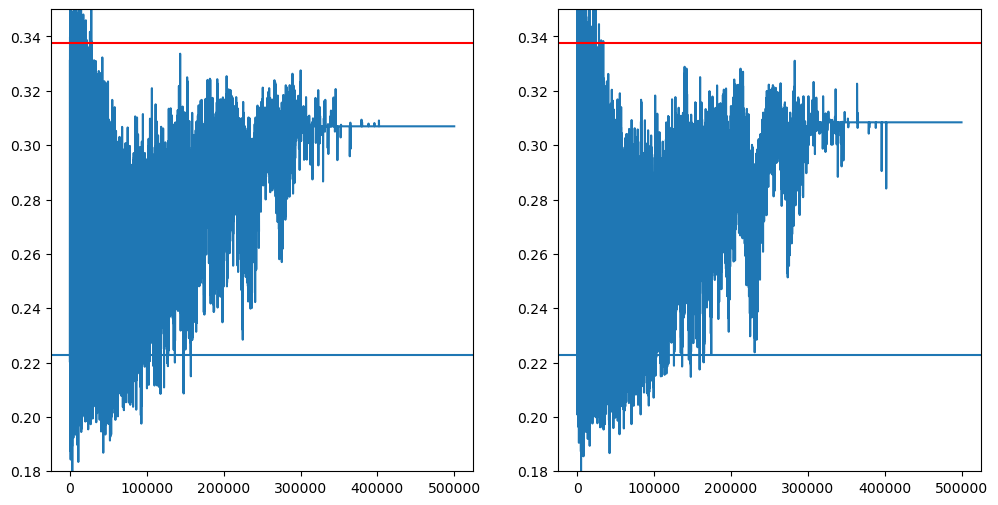

In [145]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.plot(pd.DataFrame(all_exper_rewards_1).mean(axis=0))
ax2.plot(pd.DataFrame(all_exper_rewards_2).mean(axis=0))

ax1.set_ylim(0.18, .35)
ax2.set_ylim(0.18, .35)

ax1.axhline(0.47137645*.47293, 0, total_iterations)
ax2.axhline(0.47137645*.47293, 0, total_iterations)

ax1.axhline(0.36486244*.92498, 0, total_iterations, c='red')
ax2.axhline(0.36486244*.92498, 0, total_iterations, c='red')

print(f"""gamma: {gamma}, 
        learning: {learning_rate},
        tau: {tau}, 
        beta: {beta_}""")

gamma: 0.99, 
        learning: 0.025,
        tau: 0.025, 
        beta: 1e-05


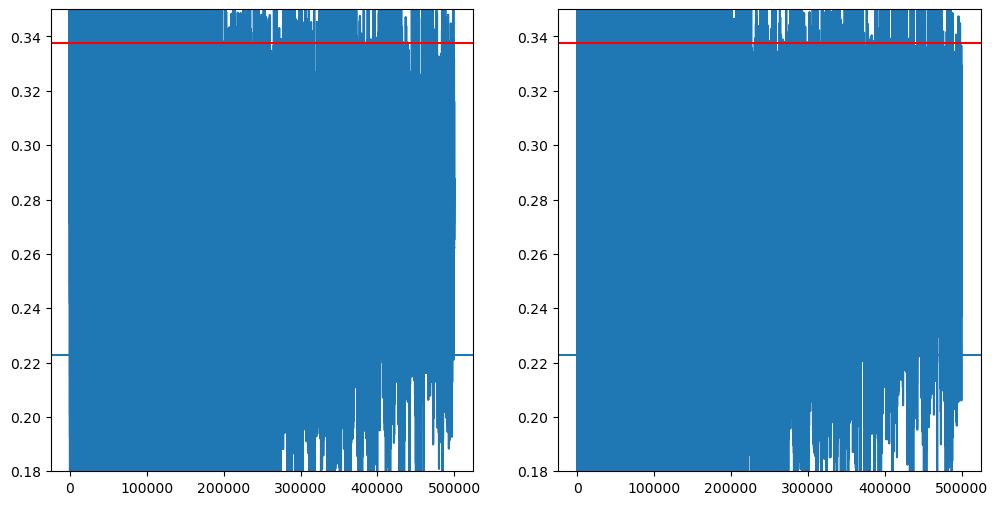

In [149]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.plot(pd.DataFrame(all_exper_rewards_1).mean(axis=0))
ax2.plot(pd.DataFrame(all_exper_rewards_2).mean(axis=0))

ax1.set_ylim(0.18, .35)
ax2.set_ylim(0.18, .35)

ax1.axhline(0.47137645*.47293, 0, total_iterations)
ax2.axhline(0.47137645*.47293, 0, total_iterations)

ax1.axhline(0.36486244*.92498, 0, total_iterations, c='red')
ax2.axhline(0.36486244*.92498, 0, total_iterations, c='red')

print(f"""gamma: {gamma}, 
        learning: {learning_rate},
        tau: {tau}, 
        beta: {beta_}""")

gamma: 0.999, 
        learning: 0.025,
        tau: 0.075, 
        beta: 0.0003


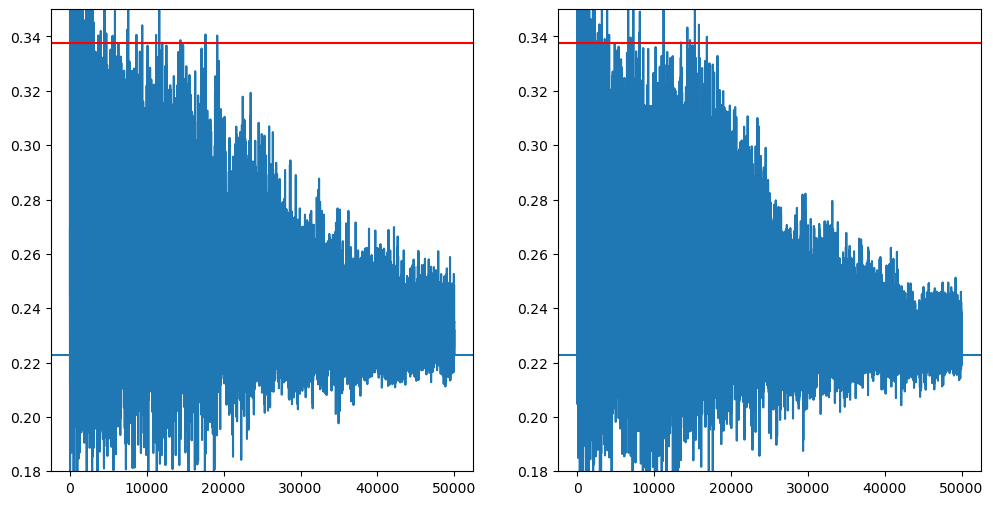

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.plot(pd.DataFrame(all_exper_rewards_1).mean(axis=0))
ax2.plot(pd.DataFrame(all_exper_rewards_2).mean(axis=0))

ax1.set_ylim(0.18, .35)
ax2.set_ylim(0.18, .35)

ax1.axhline(0.47137645*.47293, 0, total_iterations)
ax2.axhline(0.47137645*.47293, 0, total_iterations)

ax1.axhline(0.36486244*.92498, 0, total_iterations, c='red')
ax2.axhline(0.36486244*.92498, 0, total_iterations, c='red')

print(f"""gamma: {gamma}, 
        learning: {learning_rate},
        tau: {tau}, 
        beta: {beta_}""")

In [49]:
np.log(0.01)/150000

-3.070113457325394e-05

In [146]:
monopoly_ = 0.36486244*.92498
bertrand_ = 0.47137645*.47293

p1_mean = pd.DataFrame(all_exper_rewards_1).mean(axis=0).tail(1000).mean()
p2_mean = pd.DataFrame(all_exper_rewards_2).mean(axis=0).tail(1000).mean()

mean_prof = np.mean([p1_mean, p2_mean])
(mean_prof- bertrand_)/(monopoly_ - bertrand_)

0.7397000365297469

gamma: 0.99, 
        learning: 0.025,
        tau: 0.05


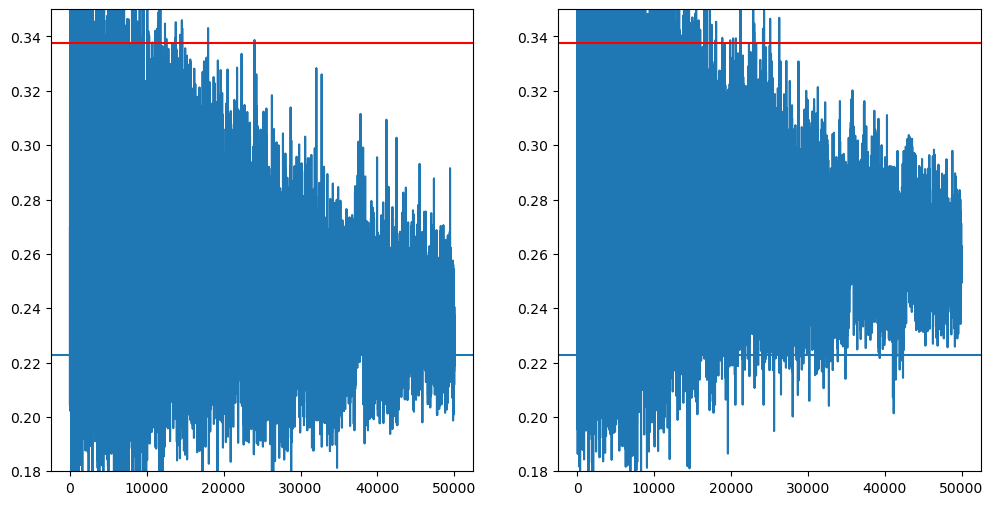

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.plot(pd.DataFrame(all_exper_rewards_1).mean(axis=0))
ax2.plot(pd.DataFrame(all_exper_rewards_2).mean(axis=0))

ax1.set_ylim(0.18, .35)
ax2.set_ylim(0.18, .35)

ax1.axhline(0.47137645*.47293, 0, total_iterations)
ax2.axhline(0.47137645*.47293, 0, total_iterations)

ax1.axhline(0.36486244*.92498, 0, total_iterations, c='red')
ax2.axhline(0.36486244*.92498, 0, total_iterations, c='red')

print(f"""gamma: {gamma}, 
        learning: {learning_rate},
        tau: {tau}""")

gamma: 0.99, 
        learning: 0.025,
        tau: 0.025


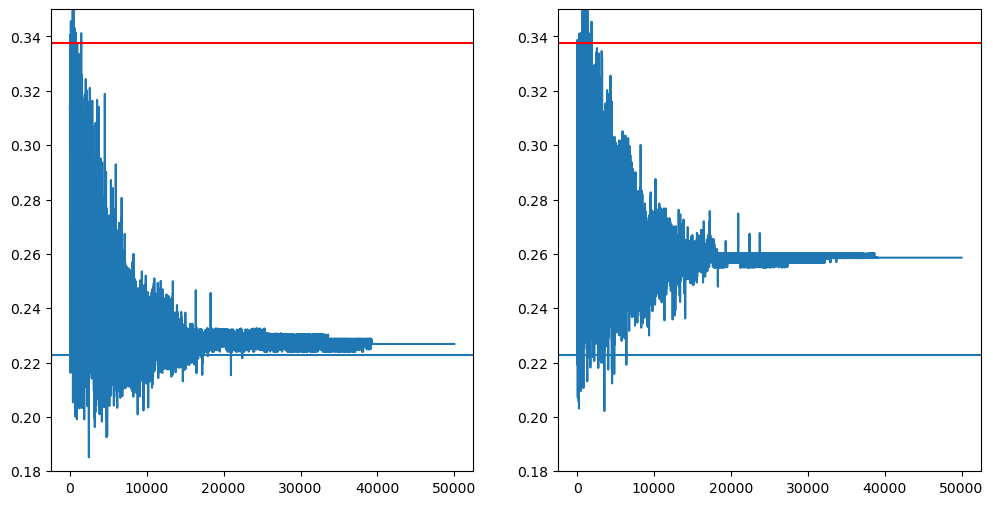

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.plot(pd.DataFrame(all_exper_rewards_1).mean(axis=0))
ax2.plot(pd.DataFrame(all_exper_rewards_2).mean(axis=0))

ax1.set_ylim(0.18, .35)
ax2.set_ylim(0.18, .35)

ax1.axhline(0.47137645*.47293, 0, total_iterations)
ax2.axhline(0.47137645*.47293, 0, total_iterations)

ax1.axhline(0.36486244*.92498, 0, total_iterations, c='red')
ax2.axhline(0.36486244*.92498, 0, total_iterations, c='red')

print(f"""gamma: {gamma}, 
        learning: {learning_rate},
        tau: {tau}""")

In [150]:
# Multiagents

import numpy as np

class SimpleEconEnvironmentFive:
    def __init__(self, mu=0.25, a_vec=np.array([0,2,2,2,2,2])):
        self.mu = mu
        self.a_vec = a_vec
    
    def aggregate_demand(self, p1, p2, p3, p4, p5):
        p_vec = np.array([0, p1, p2, p3, p4, p5])
        all_terms = np.exp((self.a_vec - p_vec)/self.mu)
        return (all_terms / np.sum(all_terms))[1:]
    
    def __call__(self, p1, p2, p3, p4, p5):
        return self.aggregate_demand(p1, p2, p3, p4, p5)

In [162]:
env_abd = SimpleEconEnvironmentFive()
env_abd(1.2082229999999998, 1.2082229999999998, 1.2082229999999998, 1.2082229999999998, 1.2082229999999998)

array([0.19832907, 0.19832907, 0.19832907, 0.19832907, 0.19832907])

In [181]:
1.27293 - 0.1*(1.92-1.27293)

1.2082229999999998

In [182]:
0.19786567*(.2082229999999998)

0.04120018340440996

In [194]:
## Simulation 
# Parameters

# Low batch size is better
# Low state memory is better


for  architec_ in [7]:
    players=5
    state_memory=1
    n_actions = 15
    gamma = 0.99

    batch_size=64
    total_iterations = 500000
    shift_delay =1
    
    #architec_ = 5

    beta_ = 2.5e-5
    total_experiments = 5

    # Initialize enviornment, state and action dict
    envir_two_agents = SimpleEconEnvironmentFive(mu=0.25)

    linspace_ = np.linspace(1.27293 - 0.1*(1.92-1.27293),
                            1.92  + 0.1*(1.92-1.27293), 
                            15)
    action_dict = dict(zip(range(15), linspace_))

    # To catch results
    all_exper_rewards_1 = []
    all_exper_rewards_2 = []
    all_exper_rewards_3 = []
    all_exper_rewards_4 = []
    all_exper_rewards_5 = []

    for experiment_ in range(total_experiments):
        print(f"Starting experiment No.: {experiment_}")

        epsilon_init = 0.9

        tau = 0.025
        tau_decay=0
        learning_rate=0.025
        lr_decay = 0.0001

        replay_buffer_1 = ReplayMemory(1000)
        replay_buffer_2 = ReplayMemory(1000)
        replay_buffer_3 = ReplayMemory(1000)
        replay_buffer_4 = ReplayMemory(1000)
        replay_buffer_5 = ReplayMemory(1000)

        # Initialize nets
        # Agent 1
        policy_net_a1 = BaseMLP([architec_,architec_,architec_],
                                input_size=state_memory*players,
                                output_size=n_actions)
        policy_net_a1.apply(init_weights)
        
        target_net_a1 = BaseMLP([architec_,architec_,architec_], input_size=state_memory*players, output_size=n_actions)
        target_net_a1.load_state_dict(policy_net_a1.state_dict())
        optimizer_a1 = optim.AdamW(policy_net_a1.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0.000001)

        # Agent 2
        policy_net_a2 = BaseMLP([architec_,architec_,architec_], input_size=state_memory*players, output_size=n_actions)
        policy_net_a2.apply(init_weights)

        target_net_a2 = BaseMLP([architec_,architec_, architec_], input_size=state_memory*players, output_size=n_actions)
        target_net_a2.load_state_dict(policy_net_a2.state_dict())
        optimizer_a2 = optim.AdamW(policy_net_a2.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0.000001)

        # Agent 3
        policy_net_a3 = BaseMLP([architec_,architec_,architec_], input_size=state_memory*players, output_size=n_actions)
        policy_net_a3.apply(init_weights)

        target_net_a3 = BaseMLP([architec_,architec_, architec_], input_size=state_memory*players, output_size=n_actions)
        target_net_a3.load_state_dict(policy_net_a3.state_dict())
        optimizer_a3 = optim.AdamW(policy_net_a3.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0.000001)

        # Agent 4
        policy_net_a4 = BaseMLP([architec_,architec_,architec_], input_size=state_memory*players, output_size=n_actions)
        policy_net_a4.apply(init_weights)

        target_net_a4 = BaseMLP([architec_,architec_, architec_], input_size=state_memory*players, output_size=n_actions)
        target_net_a4.load_state_dict(policy_net_a4.state_dict())
        optimizer_a4 = optim.AdamW(policy_net_a4.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0.000001)

        # Agent 5
        policy_net_a5 = BaseMLP([architec_,architec_,architec_], input_size=state_memory*players, output_size=n_actions)
        policy_net_a5.apply(init_weights)

        target_net_a5 = BaseMLP([architec_,architec_, architec_], input_size=state_memory*players, output_size=n_actions)
        target_net_a5.load_state_dict(policy_net_a5.state_dict())
        optimizer_a5 = optim.AdamW(policy_net_a5.parameters(), lr=learning_rate, amsgrad=True, weight_decay=0.00001)

        # Initialize a state
        np.random.seed(experiment_)
        state = torch.tensor(np.random.uniform(low=1.27,
                                            high=2,
                                            size=(players*state_memory,)),
                            dtype=torch.float32).reshape(1,players*state_memory)

        rewards_a1 = []
        rewards_a2 = []
        rewards_a3 = []
        rewards_a4 = []
        rewards_a5 = []

        for train_iter_ in range(total_iterations):

            if train_iter_ > batch_size:

                action_a1 = select_action_training(policy_net_a1, state, epsilon_init)
                action_value_a1 = int(action_a1.detach().numpy()[0])
                price_a1 = action_dict[action_value_a1]

                action_a2 = select_action_training(policy_net_a2, state, epsilon_init)
                action_value_a2 = int(action_a2.detach().numpy()[0])
                price_a2 = action_dict[action_value_a2]

                action_a3 = select_action_training(policy_net_a3, state, epsilon_init)
                action_value_a3 = int(action_a3.detach().numpy()[0])
                price_a3 = action_dict[action_value_a3]

                action_a4 = select_action_training(policy_net_a4, state, epsilon_init)
                action_value_a4 = int(action_a4.detach().numpy()[0])
                price_a4 = action_dict[action_value_a4]

                action_a5 = select_action_training(policy_net_a5, state, epsilon_init)
                action_value_a5 = int(action_a5.detach().numpy()[0])
                price_a5 = action_dict[action_value_a5]

                price_tensor = torch.tensor([price_a1, price_a2, price_a3, price_a4, price_a5], 
                                            dtype=torch.float32).reshape(1,-1)
                
                demand_1, demand_2, demand_3, demand_4, demand_5 = envir_two_agents(price_a1, price_a2, price_a3, price_a4, price_a5)

                reward_a1 = torch.tensor((price_a1 - 1)*demand_1).reshape(1,-1)
                reward_a2 = torch.tensor((price_a2 - 1)*demand_2).reshape(1,-1)
                reward_a3 = torch.tensor((price_a3 - 1)*demand_3).reshape(1,-1)
                reward_a4 = torch.tensor((price_a4 - 1)*demand_4).reshape(1,-1)
                reward_a5 = torch.tensor((price_a5 - 1)*demand_5).reshape(1,-1)

                rewards_a1.append((price_a1 - 1)*demand_1)
                rewards_a2.append((price_a2 - 1)*demand_2)
                rewards_a3.append((price_a3 - 1)*demand_3)
                rewards_a4.append((price_a4 - 1)*demand_4)
                rewards_a5.append((price_a5 - 1)*demand_5)

                next_state = torch.cat([state[:,players:], price_tensor], 1)

                replay_buffer_1.push(state, action_a1.reshape(1,1), next_state, reward_a1)
                replay_buffer_2.push(state, action_a2.reshape(1,1), next_state, reward_a2)
                replay_buffer_3.push(state, action_a3.reshape(1,1), next_state, reward_a3)
                replay_buffer_4.push(state, action_a4.reshape(1,1), next_state, reward_a4)
                replay_buffer_5.push(state, action_a5.reshape(1,1), next_state, reward_a5)

                # Train policy model 
                train_model(replay_buffer_1, policy_net_a1, target_net_a1, optimizer_a1, batch_size=batch_size)
                train_model(replay_buffer_2, policy_net_a2, target_net_a2, optimizer_a2, batch_size=batch_size)
                train_model(replay_buffer_3, policy_net_a3, target_net_a3, optimizer_a3, batch_size=batch_size)
                train_model(replay_buffer_4, policy_net_a4, target_net_a4, optimizer_a4, batch_size=batch_size)
                train_model(replay_buffer_5, policy_net_a5, target_net_a5, optimizer_a5, batch_size=batch_size)

                state = next_state

    #            epsilon_init = epsilon_init*(1-epsilon_decay)
                epsilon_init = np.exp(-(train_iter_-batch_size)*beta_)


                if train_iter_ % shift_delay == 0:
                    soft_update_nets(policy_net_a1, target_net_a1, tau)
                    soft_update_nets(policy_net_a2, target_net_a2, tau)
                    soft_update_nets(policy_net_a3, target_net_a3, tau)
                    soft_update_nets(policy_net_a4, target_net_a4, tau)
                    soft_update_nets(policy_net_a5, target_net_a5, tau)

                    tau = tau*(1-tau_decay)
            
            else:
                action_a1 = select_action_training(policy_net_a1, state, epsilon_init)
                action_value_a1 = int(action_a1.detach().numpy()[0])
                price_a1 = action_dict[action_value_a1]

                action_a2 = select_action_training(policy_net_a2, state, epsilon_init)
                action_value_a2 = int(action_a2.detach().numpy()[0])
                price_a2 = action_dict[action_value_a2]

                action_a3 = select_action_training(policy_net_a3, state, epsilon_init)
                action_value_a3 = int(action_a3.detach().numpy()[0])
                price_a3 = action_dict[action_value_a3]

                action_a4 = select_action_training(policy_net_a4, state, epsilon_init)
                action_value_a4 = int(action_a4.detach().numpy()[0])
                price_a4 = action_dict[action_value_a4]

                action_a5 = select_action_training(policy_net_a5, state, epsilon_init)
                action_value_a5 = int(action_a5.detach().numpy()[0])
                price_a5 = action_dict[action_value_a5]

                price_tensor = torch.tensor([price_a1, price_a2, price_a3, price_a4, price_a5], 
                                            dtype=torch.float32).reshape(1,-1)
                
                demand_1, demand_2, demand_3, demand_4, demand_5 = envir_two_agents(price_a1, price_a2, price_a3, price_a4, price_a5)

                reward_a1 = torch.tensor((price_a1 - 1)*demand_1).reshape(1,-1)
                reward_a2 = torch.tensor((price_a2 - 1)*demand_2).reshape(1,-1)
                reward_a3 = torch.tensor((price_a3 - 1)*demand_3).reshape(1,-1)
                reward_a4 = torch.tensor((price_a4 - 1)*demand_4).reshape(1,-1)
                reward_a5 = torch.tensor((price_a5 - 1)*demand_5).reshape(1,-1)

                next_state = torch.cat([state[:,players:], price_tensor], 1)

                replay_buffer_1.push(state, action_a1.reshape(1,1), next_state, reward_a1)
                replay_buffer_2.push(state, action_a2.reshape(1,1), next_state, reward_a2)
                replay_buffer_3.push(state, action_a3.reshape(1,1), next_state, reward_a3)
                replay_buffer_4.push(state, action_a4.reshape(1,1), next_state, reward_a4)
                replay_buffer_5.push(state, action_a5.reshape(1,1), next_state, reward_a5)

                state = next_state

        all_exper_rewards_1.append(rewards_a1)
        all_exper_rewards_2.append(rewards_a2)
        all_exper_rewards_3.append(rewards_a3)
        all_exper_rewards_4.append(rewards_a4)
        all_exper_rewards_5.append(rewards_a5)

        print(np.mean(rewards_a1[-1000:]))
        print(np.mean(rewards_a2[-1000:]))
        print(np.mean(rewards_a3[-1000:]))
        print(np.mean(rewards_a4[-1000:]))
        print(np.mean(rewards_a5[-1000:]))



    # print(batch_size)
    # monopoly_ = 0.36486244*.92498
    # bertrand_ = 0.47137645*.47293

    # p1_mean = pd.DataFrame(all_exper_rewards_1).mean(axis=0).tail(1000).mean()
    # p2_mean = pd.DataFrame(all_exper_rewards_2).mean(axis=0).tail(1000).mean()

    # mean_prof = np.mean([p1_mean, p2_mean])
    # print((mean_prof- bertrand_)/(monopoly_ - bertrand_))

Starting experiment No.: 0
0.06300262047555441
0.06300262047555441
0.06300262047555441
0.06300262047555441
0.06300262047555441
Starting experiment No.: 1
0.06300262047555441
0.06300262047555441
0.06300262047555441
0.06300262047555441
0.06300262047555441
Starting experiment No.: 2


KeyboardInterrupt: 

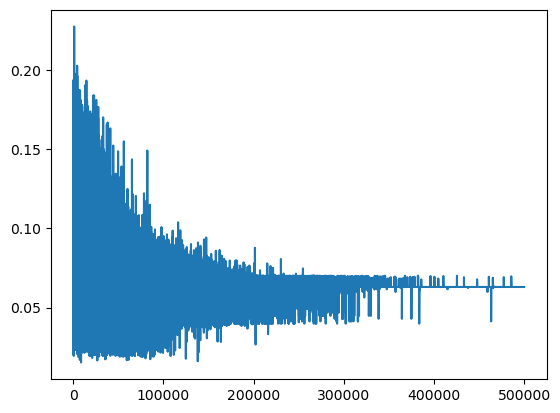

In [217]:
plt.plot(pd.DataFrame(all_exper_rewards_1).mean(axis=0))

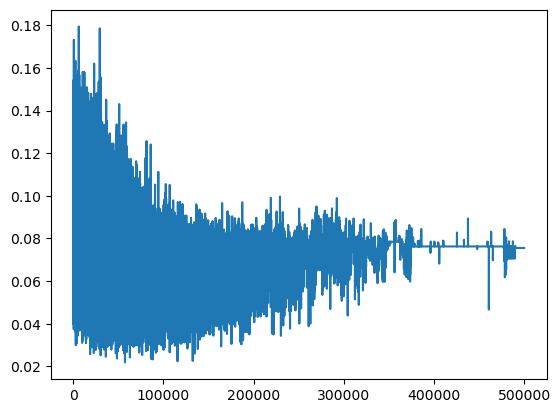

In [190]:
plt.plot(pd.DataFrame(all_exper_rewards_5).mean(axis=0))

In [189]:
# pd.DataFrame(all_exper_rewards_1).to_csv('~/Downloads/five_actors_res_1.csv', index=False)
# pd.DataFrame(all_exper_rewards_2).to_csv('~/Downloads/five_actors_res_2.csv', index=False)
# pd.DataFrame(all_exper_rewards_3).to_csv('~/Downloads/five_actors_res_3.csv', index=False)
# pd.DataFrame(all_exper_rewards_4).to_csv('~/Downloads/five_actors_res_4.csv', index=False)
# pd.DataFrame(all_exper_rewards_5).to_csv('~/Downloads/five_actors_res_5.csv', index=False)

In [218]:
k_ = pd.read_csv('~/Downloads/five_actors_res_1.csv')

In [221]:
0.084095

0.084095

In [220]:
k_.mean(axis=0).tail(1000)

498935    0.084095
498936    0.084095
498937    0.084095
498938    0.084095
498939    0.084095
            ...   
499930    0.084095
499931    0.084095
499932    0.084095
499933    0.084095
499934    0.084095
Length: 1000, dtype: float64

In [171]:
#pd.DataFrame(all_exper_rewards_1).to_csv('~/Downloads/five_actors_1.csv', index=False)

KeyboardInterrupt: 

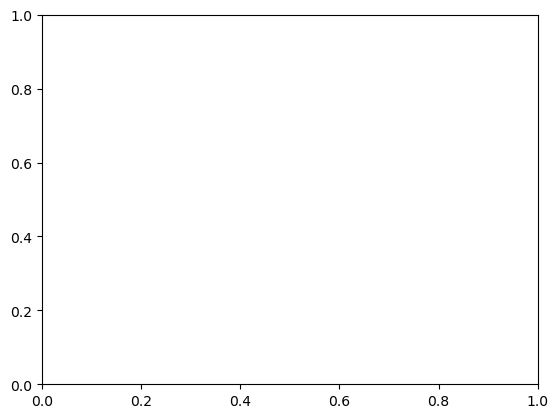

In [165]:
plt.plot(all_exper_pd.DataFrame(all_exper_rewards_1)rewards_5)